In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import signal

### Read this First

#### Remember that `tab` is is useful for autocompletion.

#### Remember that `shift + tab` is useful for rapidly obtaining usage + documentation.

###**3D Camera Geometry**

**In class we covered material for single and multi-camera systems. This notebook will help ground some of these geometric concepts.**

**First, we'll define some of the components helpful for for camera geometry**

In [2]:
def rotatex(t) :
  """ Creates a 3D rotation matrix representing a rotation about the x-axis by t radians """
  return np.array([[1,0,0],[0,np.cos(t),-np.sin(t)],[0,np.sin(t),np.cos(t)]])

def rotatey(t) :
  """ Creates a 3D rotation matrix representing a rotation about the y-axis by t radians """
  return np.array([[np.cos(t),0,np.sin(t)],[0,1,0],[-np.sin(t),0,np.cos(t)]])

def rotatez(t) :
  """ Creates a 3D rotation matrix representing a rotation about the z-axis by t radians """
  return [[np.cos(t),-np.sin(t),0],[np.sin(t),np.cos(t),0],[0,0,1]]

def rotate2D(t) :
  """ Creates a 2D rotation matrix representing a rotation by t radians """
  return [[np.cos(t),-np.sin(t)],[np.sin(t),np.cos(t)]]

def trans(x,y,z) :
  """ Creates a 3D translation vector of shape 3x1 """
  return np.array([[x,y,z]]).T

def pointh(x,y,z) :
  """ Creates a 3D point in homogeneous coordinates """
  return np.array([[x,y,z,1]].T)

def htrans(R,t) :
  """ Creates a 3D homogeneous transformation matrix """
  return np.concatenate((np.concatenate((R,t),axis=1),np.array([[0,0,0,1]])))

**Now, we'll define some components for camera internal geometry**

In [3]:
def Kmatrix(sx,sy,ox,oy) :
  """ Creates the matrix K that represents the calibration matrix """
  return np.array([[sx,0,ox],[0,sy,oy],[0,0,1]])

def Mmatrix(K) :
  """ Creates the matrix M that represents the intrinsic matrix """
  return np.concatenate((K, np.array([[0,0,0]]).T),axis=1)

**Now, write a function that, given a intrinsic matrix M and a extrinsic matrix H, computes the projection matrix P.** 

In [4]:
def Pmatrix(M, H):
  """ Creates a 3x4 projection matrix P that relates world coordinates to pixel coordinates
      Args:
        M: 3x4 matrix representing the intrinsic parameters of the camera
        H: 4x4 matrix representing the extrinsic parameters of the camera
      Return:
        P: 3x4 matrix relating world coordinates to pixel coordinates
  """
  P = M @ H
  return P

**Now, let's make some real world points to project.  Since this is a camera, we'll make the z axis larger than x and y**

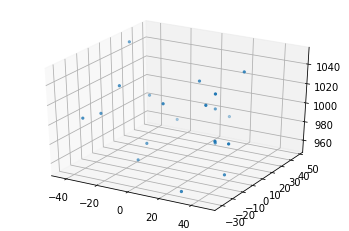

In [5]:
# Make 20 random 3D points stacked horizontally 
pts = np.concatenate((np.random.random([3,20]),np.ones([1,20])),axis=0)
pts[0:2,:] = (pts[0:2,:] - 0.5) * 100
pts[2,:] = (pts[2,:] - 0.5) * 100 + 1000

# Plot these points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.scatter(pts[0],pts[1],zs=pts[2],s=5)

**Create an K matrix with parameters $s_x=s_y=1000$, $o_x=52.2$, $o_y=55.3$. Create a H matrix with identity rotation and a translation $(x, y, z)=(42, 33, 1000)$. Then, using those, create the P matrix and print the resulting matrix.**

In [6]:
K = np.array([[1000, 0, 52.2, 0], [0, 1000, 55.3, 0], [0, 0, 1, 0]])
H = np.array([[1, 0, 0, 42], [0, 1, 0, 33], [0, 0, 1, 1000], [0, 0, 0, 1]])

P = Pmatrix(K, H)
print(P)

[[1.00e+03 0.00e+00 5.22e+01 9.42e+04]
 [0.00e+00 1.00e+03 5.53e+01 8.83e+04]
 [0.00e+00 0.00e+00 1.00e+00 1.00e+03]]


**Transform our real world points pts using this projection matrix and store the resulting pixel coordinates into pix_pts. Remember that the results are in homogeneous coordinates so when we plot it we have to ensure that $w=1$ for hoomogeneous coordinate $(u, v, w)$**

(3, 20)


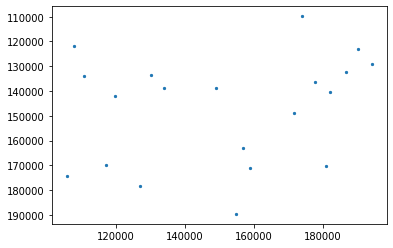

In [7]:
pix_pts = P @ pts

print(pix_pts.shape)

# Plot these points
fig = plt.figure()
plt.scatter(pix_pts[0], pix_pts[1], s=5)
plt.gca().invert_yaxis()

**Why did I invert the y axis here?**

The due to the way pinhole cameras work, the resulting image ends up being flipped, since light rays that originate higher up in the vertical dircetion cross the origin and hit the image plane on a lower region, while the opposite is true for light rays that originate in the world coordinates from lower on the vertical axis. The same thing happens along the horizontal axis. So to display an image in the way that preserves world coordinate vertical orientation, we must flip the y axis.

**Now we want to compare this with the plot of pts above to see how similar our camera view with the real world. Plot pts as before using scatter, but now adjust viewpoint of the plot to have elevation as $-90$ and azimuth as $-90$.**

Text(0.5, 0, 'Z Label')

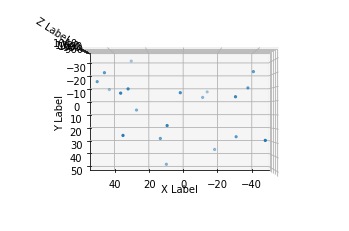

In [8]:
# Plot pts again but with a different viewpoint
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 90)
plt.scatter(pts[0],pts[1],zs=pts[2],s=5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

**Which directions are the x, y, and z axes? (i.e. which is the vertical/horizontal/in or out of plane axis? Which direction is the positive direction for each?)**

Vertical is y, horizontal is x, out of page is z


**Do your camera points look the same as the real world points? (They should)**

Thy look the same except they are flipped horizontally.

**Now, change the parameters such that $o_x=0$, recompute the projection matrix, reproject the real world points to the pixel coordinates and plot it as before.**

(3, 20)


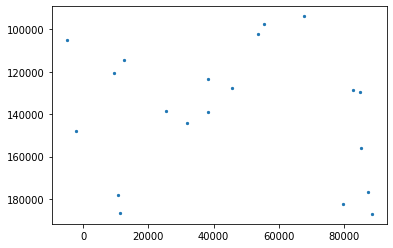

In [29]:
K = np.array([[1000, 0, 0, 0], [0, 1000, 55.3, 0], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 42], [0, 1, 0, 33], [0, 0, 1, 1000], [0, 0, 0, 1]])

P = Pmatrix(K, H)
pix_pts_l = P @ pts

print(pix_pts_l.shape)

# Plot these points
fig = plt.figure()
plt.scatter(pix_pts_l[0], pix_pts_l[1], s=5)
plt.gca().invert_yaxis()

**What changed between this and the previous plot you made? What does the parameter $o_x$ represent?**

The origin is shifted along the horizontal direction. The o_x represents the x pixel coordinate of the origin

**Now change $s_y=400$ and do the same thing. Keep $o_x=0$ so you can compare without scrolling too far.**

(3, 20)


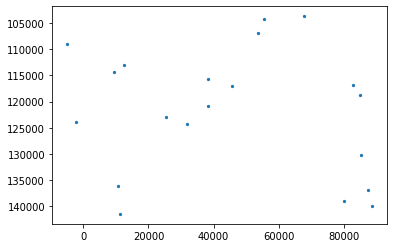

In [30]:
K = np.array([[1000, 0, 0, 0], [0, 400, 55.3, 0], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 42], [0, 1, 0, 33], [0, 0, 1, 1000], [0, 0, 0, 1]])

P = Pmatrix(K, H)
pix_pts_r = P @ pts

print(pix_pts_r.shape)

# Plot these points
fig = plt.figure()
plt.scatter(pix_pts_r[0], pix_pts_r[1], s=5)
plt.gca().invert_yaxis()

**What changed between this and the previous plot you made? What does the parameter $s_y$ represent?**

The vertical axis has a smaller scale. The s_y represents the scale of the y axis.

**Now let's try and recover the projection matrix. We've already covered this in the Week 6 Python Notebook, so it should be relatively straightforward. Using the real world coordinates pts and the pixel coordinates obtained when we set $s_y=400$ and $o_x=0$ above, create the $A$ matrix in $Ap=0$ that was covered in class to solve for the projection matrix.**

In [11]:
A = np.zeros((2 * 20, 12))

j = 0

location = pts.T
points = pix_pts.T


for i in range(20):
  l = location[i]
  p = points[i]
  A[j] = np.array([l[0], l[1], l[2], 1, 0, 0, 0, 0, -p[0] * l[0], -p[0] * l[1], -p[0] * l[2], -p[0]])
  A[j+1] = np.array([0, 0, 0, 0, l[0], l[1], l[2], 1, -p[1] * l[0], -p[1] * l[1], -p[1] * l[2], -p[1]])
  j += 2

**Compute the projection matrix P by solving for $Ap=0$, and print it. Compare it with the projection matrix computed above to confirm that they are identical.**

In [12]:
eigenValues, eigenVectors = np.linalg.eig(A.T @ A)

idx = eigenValues.argsort()  
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

v = eigenVectors[:, 0]

p = np.zeros((3,4))
p[0] = v[:4]
p[1] = v[4:8]
p[2] = v[8:]

p /= p[2,]

print(p.round())

[[ 2.85183656e+09  6.90350000e+04  6.78830000e+04  4.19870000e+04]
 [ 1.22939000e+05 -1.95433897e+09  1.08060218e+08  6.84700000e+04]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]


**Recover the K and R matrices, and then the translation vector t using RQ factorization, and print them to make sure they are consistent with the parameters that you provided to create the projection matrix.**

In [13]:
R, K = np.linalg.qr(p[:, :3])
t = np.linalg.inv(K) @ p[:, 3]
# t /= 3

print(K.round())
print(R.round())
print(t.round())

[[-2.85183656e+09  1.52140000e+04 -7.25420000e+04]
 [ 0.00000000e+00  1.95433897e+09 -1.08060215e+08]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-1.  0. -0.]
 [-0. -1.  0.]
 [-0.  0.  1.]]
[-0.  0.  1.]


**Now pick your own parameters for the intrinsic and extrinsic matrices, project pts, and then recover the projection matrix P. Double check that you're able to recover the matrix.**

(3, 20)
[[-5.1705764e+07  2.2872900e+05  1.8548030e+06  1.1863900e+05]
 [ 4.0905000e+04  2.0321381e+07  3.6100300e+05  3.0142000e+04]
 [ 1.0000000e+00  1.0000000e+00  1.0000000e+00  1.0000000e+00]]
[[ 5.1705780e+07 -2.1265200e+05 -1.8545170e+06]
 [ 0.0000000e+00 -2.0321555e+07 -3.6247000e+05]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[[-1. -0.  0.]
 [ 0. -1. -0.]
 [ 0. -0.  1.]]
[ 0. -0.  1.]


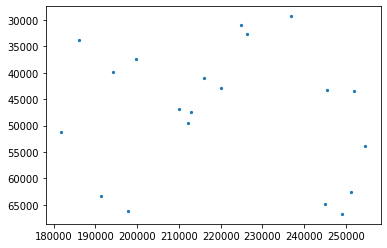

In [26]:
K = np.array([[730, 0, 94, 0], [0, 400, 18, 0], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 42], [0, 1, 0, 33], [0, 0, 1, 1000], [0, 0, 0, 1]])

P = Pmatrix(K, H)
pix_pts = P @ pts

print(pix_pts.shape)

# Plot these points
fig = plt.figure()
plt.scatter(pix_pts[0], pix_pts[1], s=5)
plt.gca().invert_yaxis()


A = np.zeros((2 * 20, 12))

j = 0

location = pts.T
points = pix_pts.T


for i in range(20):
  l = location[i]
  p = points[i]
  A[j] = np.array([l[0], l[1], l[2], 1, 0, 0, 0, 0, -p[0] * l[0], -p[0] * l[1], -p[0] * l[2], -p[0]])
  A[j+1] = np.array([0, 0, 0, 0, l[0], l[1], l[2], 1, -p[1] * l[0], -p[1] * l[1], -p[1] * l[2], -p[1]])
  j += 2

eigenValues, eigenVectors = np.linalg.eig(A.T @ A)

idx = eigenValues.argsort()  
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

v = eigenVectors[:, 0]

p = np.zeros((3,4))
p[0] = v[:4]
p[1] = v[4:8]
p[2] = v[8:]

p /= p[2,]

print(p.round())

R, K = np.linalg.qr(p[:, :3])
t = np.linalg.inv(K) @ p[:, 3]
# t /= 3

print(K.round())
print(R.round())
print(t.round())

###**Uncalibrated stereo**

**Now that we're more confident with single camera geometry, let's try relate the geometries and the viewpoints of two cameras. The goal of this is to be able to find a relationship between the location of an object in one camera view and the location of the object in the other camera view.**

**Here, let's create 20 random points again** 

In [14]:
# Make 20 random 3D points stacked horizontally 
npoints = 20
pts = np.concatenate((np.random.random([3, npoints]),np.ones([1, npoints])),axis=0)
pts[0:2,:] = (pts[0:2,:] - 0.5) * 100
pts[2,:] = (pts[2,:] - 0.5) * 100 + 1000
colors = plt.cm.rainbow(np.linspace(0, 1, npoints))

**We also plot these points, is a couple of different views that will make more sense that the default view.**

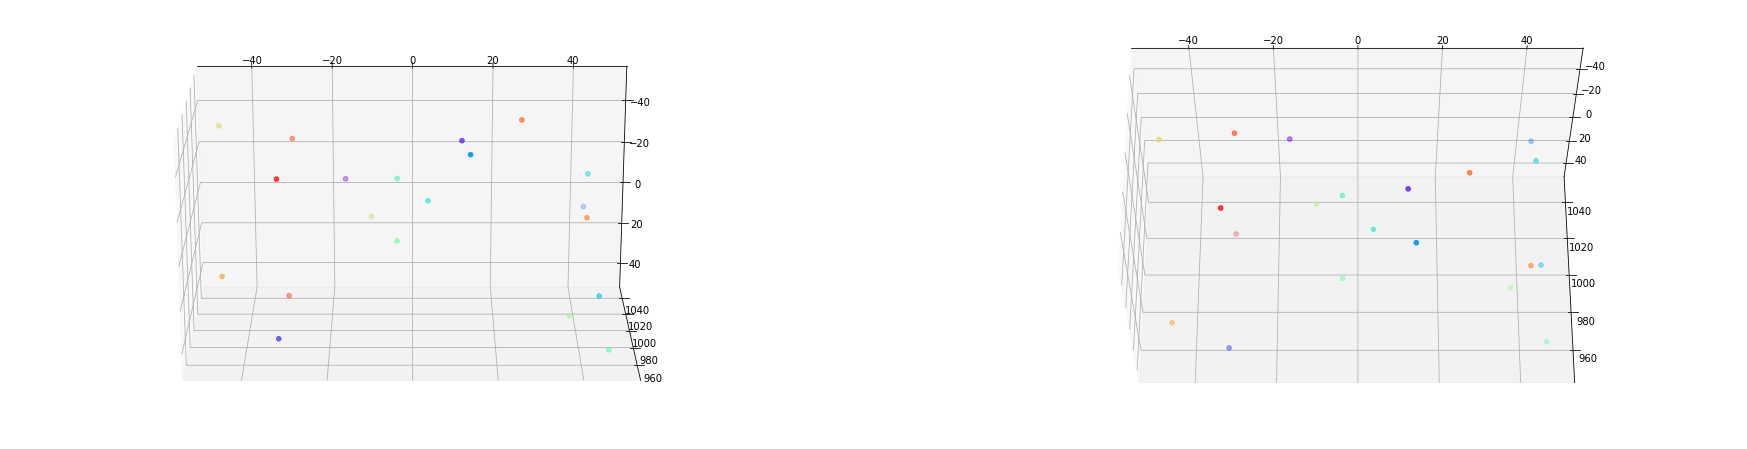

In [15]:
# Plot these points
fig = plt.figure(figsize=(48, 8))
ax = fig.add_subplot(131, projection='3d')
plt.scatter(pts[0],pts[1],zs=pts[2],s=21, c=colors)
ax.view_init(elev=-70, azim=-90)

ax2 = fig.add_subplot(132, projection='3d')
plt.scatter(pts[0],pts[1],zs=pts[2],s=21, c=colors)
ax2.view_init(elev=-30, azim=-90)

**Now we want to simulate two cameras. For camera 1, create a projection matrix with parameters $s_x=s_y=1000$, $o_x=35$, $o_y=55.3$, with a y-axis rotation by -0.3 radians, and a translation vector of $[280, 33, 1000]$.** 

**Project the real world pts above into the view of this camera, and plot these pixel coordinates with the same colours as above corresponding to each point (set c=colors) and remember to invert the y-axis.**

(3, 20)


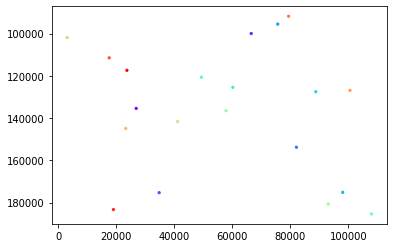

In [16]:
K = np.array([[1000, 0, 35, 0], [0, 1000, 55.3, 0], [0, 0, 1, 0]])
H = np.identity(4)
H[:3,:3] = rotatey(-0.3)
H[:,3] = np.array([280, 33, 1000, 1])

P = Pmatrix(K, H)
left = P @ pts

print(left.shape)

# Plot these points
fig = plt.figure()
plt.scatter(left[0], left[1], s=5, c=colors)
plt.gca().invert_yaxis()

**Now simulate camera 2, by creating a projection matrix with parameters $s_x=s_y=1000$, $o_x=35$, $o_y=55.3$, with a y-axis rotation by 0.3 radians, and a translation vector of $[390, 33, 1000]$.** 

**Project the real world pts above into the view of this camera, and plot these pixel coordinates with the same colours as above corresponding to each point (set c=colors) and remember to invert the y-axis.**

(3, 20)


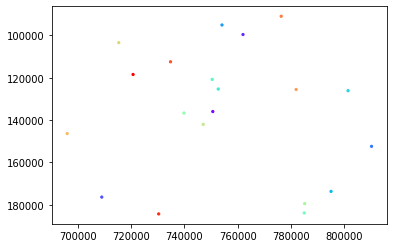

In [17]:
K = np.array([[1000, 0, 35, 0], [0, 1000, 55.3, 0], [0, 0, 1, 0]])
H = np.identity(4)
H[:3,:3] = rotatey(0.3)
H[:,3] = np.array([390, 33, 1000, 1])

P = Pmatrix(K, H)
right = P @ pts

print(right.shape)

# Plot these points
fig = plt.figure()
plt.scatter(right[0], right[1], s=5, c=colors)
plt.gca().invert_yaxis()

**Which camera is the camera on the left? How can you tell?**

The first camera is on the left since the x coordinate is smaller and the rotation is to the right.

**Now we have the pixel coordiantes in both images and we know which pairs of points correspond to each other, we can solve for the fundamental matrix, which relates pixel coordinates from one image to another.**

**Below, fill in the matrix A that you find in slide 46**

In [18]:
A = np.zeros((npoints, 9))

leftT = left.T
rightT = right.T

for i in range(npoints):
  l = leftT[i]
  r = rightT[i]
  A[i] = np.array([l[0]*r[0], l[0]*r[1], l[0], l[1]*r[0], l[1]*r[1], l[1], r[0], r[1], 1])

**Solve for the fundamental matrix given that $Af=0$, and print out the fundamental matrix F. For reference please see slide 62.**

In [20]:
eigenValues, eigenVectors = np.linalg.eig(A.T @ A)

idx = eigenValues.argsort()  
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

v = eigenVectors[:, 0]
v /= v[-1]

F = v.reshape(3,3)
print(F.round())

[[ 0.  0. -0.]
 [-0. -0.  0.]
 [-0. -0.  1.]]


**Try and recover the essential matrix. We can do this because you already know the calibration matrices $K_r$ and $K_l$. Display the result**

In [21]:
K = np.array([[1000, 0, 35], [0, 1000, 55.3], [0, 0, 1]])
E = np.linalg.inv(K) @ F @ np.linalg.inv(K)
print(E)

[[ 4.26598206e-11  2.81721570e-09 -3.50001588e-02]
 [ 6.74025165e-11  4.45120080e-09 -5.53001680e-02]
 [-1.21885202e-09 -8.04918771e-08  1.00000449e+00]]


**Given the essential matrix, we can also recover the rotation between the two cameras. Compute $R$, the rotation between the two cameras, using the essential matrix $E$. Display it, and then using rotatey() display the actual rotation between the two cameras (check the extrinsic matrices of the cameras to determine the true rotation between them).**

In [22]:
u, s, vh = np.linalg.svd(E)
vh[:, 2] *= -1
wh = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])
R = u @ wh @ vh

print(R)
print(rotatey(0.6))


[[ 0.99958348  0.01979416  0.0210015 ]
 [ 0.01988753  0.05488699 -0.9982945 ]
 [ 0.02091311 -0.99829635 -0.05447047]]
[[ 0.82533561  0.          0.56464247]
 [ 0.          1.          0.        ]
 [-0.56464247  0.          0.82533561]]


**Are they the same? They should be.**

**Now try and recover the translation, and display the result.**

In [24]:
skt = u @ wh.T @ np.diag(s) @ u.T
t = np.array([-skt[0,1], skt[0,1], -skt[1,2]])
print(t)

[ 0.00116139 -0.00116139  0.99829898]


**Chances are, this will be different from the true translation between the cameras. Why is this so?**

Camera translation using the essential matrix is only defines translation up to direction, not magnitude.

**Now let's try and plot the epipolar lines. Write a function that given the fundamental matrix and an image pixel coordinate in either the left or the right image, returns the coefficients of the epipolar line in the other image.**

In [44]:
def findEpipolar(F, pix_l=None, pix_r=None):
  """ Computes the epipolar line coefficients given the fundamental matrix F and either
      the pixel coordinates in the left image (pix_l) or the pixel coordinates in the 
      right image (pix_r)
      Args:
        F: Fundamenal matrix 3x3 that relates pixels in one image to another
        pix_l: Pixel coordinate in the left image (shape [3, 1])
        pix_r: Pixel coordinate in the right image(shape [1, 3])
      Return:
        line_coeff: The coefficients of the epipolar line in the other image
                    If the equation is au + bv + c = 0, the line_coeff = [a, b, c]
  """

  # If the right pixel coordinate is provided, we want to find the coefficients of
  # the line in the left image
  if pix_l is None:
    line_coeff = F @ pix_r


  # If the left pixel coordinate is provided, we want to find the coefficients of 
  # the line in the right image
  elif pix_r is None:
    line_coeff = pix_l @ F

  else:
    line_coeff = None

  return line_coeff

**Now complete the function below, that given the coefficient of the line and either the $x$ or the $y$ coordinate, finds the other one.**

In [62]:
def findOther(line_coeff, u=None, v=None):
  """ Given the coefficients of au + bv + c = 0 in the form [a, b, c], compute either
      u if v is given, or v if u is given.
      Args:
        line_coeff: [a, b, c] vector of the coefficients of the equation above
        u: The x coordinate of the pixel
        v: The y coordinate of the pixel
      Return:
        The other pixel coordinate, None if nothing else is provided
  """
  a = line_coeff[0]
  b = line_coeff[1]
  c = line_coeff[2]

  if u is None:
    r = -(c + b*v) / a

  elif v is None:
    r = -(c + a*u) / b

  return r

**Now, using the two functions above, plot the epipolar lines corresponding to the points from the right image onto the left image. Plot the points in the left image in the same plot. Make sure that the colours match, and each point in the left image should have an epipolar line that passes through them.**

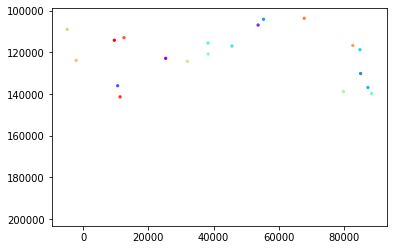

In [65]:
line_r = findEpipolar(F, pix_pts_l.T, None)

x = np.linspace(0, 8000, 1)
fig = plt.figure()
plt.scatter(pix_pts_r[0], pix_pts_r[1], s=5, c=colors)
for line in line_r:
  plt.plot(x, findOther(line, x, None))
plt.gca().invert_yaxis()

**Now do the same thing, plotting the epipolar lines corresponding to left image points onto the right image.**

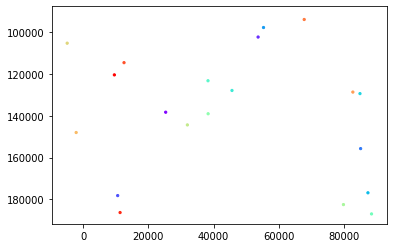

In [66]:
line_l = findEpipolar(F, None, pix_pts_r).T

x = np.linspace(0, 8000, 1)
fig = plt.figure()
plt.scatter(pix_pts_l[0], pix_pts_l[1], s=5, c=colors)
for line in line_l:
  plt.plot(x, findOther(line, x, None), c=colors[i])
plt.gca().invert_yaxis()

**Now, change the extrinsics of the right camera to include another rotation in either x or z in addition to the y rotation, find the geometry between the left camera and this new right camera, and plot the epipolar lines.**